# Скачивание датасета с Kaggle

Датасет: https://www.kaggle.com/datasets/hellbuoy/car-price-prediction  
Этот датасет был выбран из-за его простоты и веса.

Построим модель, которая предсказывает цену машины по её параметрам.


In [1]:
! pip install -q kaggle --quiet

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darkground","key":"..."}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d hellbuoy/car-price-prediction

Dataset URL: https://www.kaggle.com/datasets/hellbuoy/car-price-prediction
License(s): unknown
  0% 0.00/18.1k [00:00<?, ?B/s]
100% 18.1k/18.1k [00:00<00:00, 21.3MB/s]


In [4]:
! unzip  '/content/car-price-prediction.zip' -d '/content/car-price-prediction'

Archive:  /content/car-price-prediction.zip
  inflating: /content/car-price-prediction/CarPrice_Assignment.csv  
  inflating: /content/car-price-prediction/Data Dictionary - carprices.xlsx  


In [5]:
! pip install torchinfo --quiet

# Обработка датасета

Предварительная обработка перед обучением модели

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

car_prices_path = "/content/car-price-prediction/CarPrice_Assignment.csv"
car_prices = pd.read_csv(car_prices_path)

## One-Hot кодировка и удаление лишних полей

In [7]:
cols_to_drop = [
    'symboling', 'CarName',
    'wheelbase', 'curbweight', 'enginesize', 'boreratio',
    'compressionratio', 'enginelocation', 'fuelsystem', 'car_ID'
] # Столбцы, которые не нужны
cols_to_ohencode = [
    'fueltype', 'aspiration', 'drivewheel',
    'enginetype', 'carbody'
] # Столбцы, которые необходимо закодировать в формат one-hot
cols_to_ordencode = [
    'doornumber', 'cylindernumber'
] # Столбцы, которые необходимо закодировать в ординальный формат
cols_to_normalize = [
    'stroke', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
    'wheelbase', 'carlength', 'carwidth', 'carheight'
] # Столбцы, которые необходимо нормализовать

Уникальные значения полей, которые будут закодированы:

In [8]:
for col_to_encode in cols_to_ohencode + cols_to_ordencode:
    print(col_to_encode, car_prices[col_to_encode].unique())

fueltype ['gas' 'diesel']
aspiration ['std' 'turbo']
drivewheel ['rwd' 'fwd' '4wd']
enginetype ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
carbody ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
doornumber ['two' 'four']
cylindernumber ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']


In [9]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler

oh_encoder = OneHotEncoder(handle_unknown='ignore', dtype=np.int64, sparse_output=False)
oh_encoded = pd.DataFrame(
    oh_encoder.fit_transform(car_prices[cols_to_ohencode]),
    columns=oh_encoder.get_feature_names_out(), dtype=np.int64
)

ord_encoder = OrdinalEncoder(dtype=np.int64)
ord_encoded = pd.DataFrame(
    ord_encoder.fit_transform(car_prices[cols_to_ordencode]),
    columns=ord_encoder.get_feature_names_out(), dtype=np.int64
)

rb_scaler = RobustScaler()
rb_scaled = pd.DataFrame(
    rb_scaler.fit_transform(car_prices[cols_to_normalize]),
    columns=rb_scaler.get_feature_names_out()
)

# Отдельный scaler для цены, чтобы потом применить inverse_transform
price_scaler = RobustScaler()
price_scaled = pd.DataFrame(
    price_scaler.fit_transform(car_prices[['price']]),
    columns=price_scaler.get_feature_names_out()
)

Удаление старых столбцов и добавление новых закодированных:

In [10]:
car_prices = car_prices.drop(cols_to_ohencode, axis='columns')
car_prices = car_prices.join(oh_encoded)

car_prices = car_prices.drop(cols_to_ordencode, axis='columns')
car_prices = car_prices.join(ord_encoded)

car_prices = car_prices.drop(cols_to_normalize, axis='columns')
car_prices = car_prices.join(rb_scaled)

car_prices = car_prices.drop(['price'], axis='columns')
car_prices = car_prices.join(price_scaled)

car_prices = car_prices.drop(cols_to_drop, axis='columns')

In [11]:
print(car_prices.describe())

car_prices.head()

       fueltype_diesel  fueltype_gas  aspiration_std  aspiration_turbo  \
count       205.000000    205.000000      205.000000        205.000000   
mean          0.097561      0.902439        0.819512          0.180488   
std           0.297446      0.297446        0.385535          0.385535   
min           0.000000      0.000000        0.000000          0.000000   
25%           0.000000      1.000000        1.000000          0.000000   
50%           0.000000      1.000000        1.000000          0.000000   
75%           0.000000      1.000000        1.000000          0.000000   
max           1.000000      1.000000        1.000000          1.000000   

       drivewheel_4wd  drivewheel_fwd  drivewheel_rwd  enginetype_dohc  \
count      205.000000      205.000000      205.000000       205.000000   
mean         0.043902        0.585366        0.370732         0.058537   
std          0.205380        0.493865        0.484183         0.235330   
min          0.000000        0.000000

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginetype_dohc,enginetype_dohcv,enginetype_l,...,cylindernumber,stroke,horsepower,peakrpm,citympg,highwaympg,carlength,carwidth,carheight,price
0,0,1,1,0,0,0,1,1,0,0,...,2,-2.033333,0.347826,-0.285714,-0.272727,-0.333333,-0.261905,-0.500000,-1.514286,0.367183
1,0,1,1,0,0,0,1,1,0,0,...,2,-2.033333,0.347826,-0.285714,-0.272727,-0.333333,-0.261905,-0.500000,-1.514286,0.711991
2,0,1,1,0,0,0,1,0,0,0,...,3,0.600000,1.282609,-0.285714,-0.454545,-0.444444,-0.119048,0.000000,-0.485714,0.711991
3,0,1,1,0,0,1,0,0,0,0,...,2,0.366667,0.152174,0.428571,0.000000,0.000000,0.202381,0.250000,0.057143,0.419392
4,0,1,1,0,1,0,0,0,0,0,...,1,0.366667,0.434783,0.428571,-0.545455,-0.888889,0.202381,0.321429,0.057143,0.820998


## Разбиение датасета на тренировочную, валидационную и тестовую выборки

In [12]:
from sklearn.model_selection import train_test_split

target = ['price']

X=car_prices.drop(target, axis='columns').values
y=car_prices[target].values

X_, X_test, y_, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, train_size=0.9, random_state=42)

In [13]:
print("Количество элементов в тренировочной выборке:", len(X_train))
print("Количество элементов в валидационной выборке:", len(X_valid))
print("Количество элементов в тестовой выборке:", len(X_test))

Количество элементов в тренировочной выборке: 165
Количество элементов в валидационной выборке: 19
Количество элементов в тестовой выборке: 21


# Модель Torch

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T

In [15]:
# вычисления на графическом процессоре, если возможно
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device:", device)

Current device: cpu


## Загрузка датасета в тензоры

Размер пакета равен 16, т.к. сам датасет не очень большой

In [16]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(data).float()
      self.targets = torch.Tensor(targets).float()
      self.transform = transform

  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

  def get_labels(self):
    return self.targets

  def __len__(self):
      return len(self.data)

In [17]:
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=False) # загрузчики данных
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

## Создание самой модели

Модель состоит из трёх слоёв:
- Линейный, 29 -> 18
- Линейный, 18 -> 6
- Линейный, 6 -> 1

и активации LeakyReLU

In [18]:
class PriceGuesserModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.pipe = nn.Sequential(
            nn.Linear(29, 18),
            nn.LeakyReLU(),

            nn.Linear(18, 6),
            nn.LeakyReLU(),

            nn.Linear(6, 1)
        )

    def forward(self, x):
        return self.pipe(x)

In [19]:
model = PriceGuesserModel()
model.to(device)

PriceGuesserModel(
  (pipe): Sequential(
    (0): Linear(in_features=29, out_features=18, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=18, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=6, out_features=1, bias=True)
  )
)

In [20]:
from torchinfo import summary
summary(model, input_size=(1, 29))

Layer (type:depth-idx)                   Output Shape              Param #
PriceGuesserModel                        [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 18]                   540
│    └─LeakyReLU: 2-2                    [1, 18]                   --
│    └─Linear: 2-3                       [1, 6]                    114
│    └─LeakyReLU: 2-4                    [1, 6]                    --
│    └─Linear: 2-5                       [1, 1]                    7
Total params: 661
Trainable params: 661
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Тренировка модели

На каждой итерации выводится потеря на тренировочной и валидационной выборках

In [21]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

In [22]:
train_losses = []
val_losses = []

criterion = nn.MSELoss(reduction='mean') # функция ошибки
optimizer = torch.optim.Adam(model.parameters()) # алгоритм оптимизации

In [23]:
def train(model,epoch):
  model.train() # веса модели можно обновлять
  running_loss= 0.
  for data in tqdm(train_loader):
      inputs, targets=data[0].to(device),data[1].to(device) # распаковываем пакеты
      optimizer.zero_grad() # обнуляем градиенты
      outputs=model(inputs) # считаем предсказания - прямой проход модели
      loss=criterion(outputs,targets) # ошибка пакета
      loss.backward() # обратное распространение ошибки
      optimizer.step() # итерация алгоритма оптимизации
      running_loss += loss.item()

  train_loss=running_loss/len(train_loader)
  train_losses.append(train_loss)

  print(f'Train loss {train_loss:.4f}')

In [24]:
def val(model,epoch):
    model.eval() # веса модели заморожены
    running_loss = 0.
    with torch.no_grad(): # запрещаем переисывать градиенты
        for data in tqdm(val_loader):
            inputs, targets=data[0].to(device),data[1].to(device)
            outputs=model(inputs)
            loss=criterion(outputs,targets)

            running_loss += loss.item()

        val_loss=running_loss/len(val_loader)

        val_losses.append(val_loss)
        print(f'Validation loss {val_loss:.4f}')

In [25]:
max_epochs = 200
for epoch in range(1,max_epochs+1):
    print(f'\nEpoch: {epoch}')
    train(model,epoch)
    val(model,epoch)


Epoch: 1


100%|██████████| 11/11 [00:00<00:00, 49.09it/s]


Train loss 0.7719


100%|██████████| 2/2 [00:00<00:00, 143.98it/s]


Validation loss 1.0756

Epoch: 2


100%|██████████| 11/11 [00:00<00:00, 102.46it/s]


Train loss 0.7019


100%|██████████| 2/2 [00:00<00:00, 494.35it/s]


Validation loss 1.0276

Epoch: 3


100%|██████████| 11/11 [00:00<00:00, 156.18it/s]


Train loss 0.6382


100%|██████████| 2/2 [00:00<00:00, 361.92it/s]


Validation loss 0.9714

Epoch: 4


100%|██████████| 11/11 [00:00<00:00, 198.00it/s]


Train loss 0.5765


100%|██████████| 2/2 [00:00<00:00, 227.40it/s]


Validation loss 0.9122

Epoch: 5


100%|██████████| 11/11 [00:00<00:00, 138.09it/s]


Train loss 0.5175


100%|██████████| 2/2 [00:00<00:00, 257.57it/s]


Validation loss 0.8539

Epoch: 6


100%|██████████| 11/11 [00:00<00:00, 126.84it/s]


Train loss 0.4609


100%|██████████| 2/2 [00:00<00:00, 380.00it/s]


Validation loss 0.7909

Epoch: 7


100%|██████████| 11/11 [00:00<00:00, 221.16it/s]


Train loss 0.3964


100%|██████████| 2/2 [00:00<00:00, 616.22it/s]


Validation loss 0.7128

Epoch: 8


100%|██████████| 11/11 [00:00<00:00, 84.69it/s]


Train loss 0.3260


100%|██████████| 2/2 [00:00<00:00, 177.83it/s]


Validation loss 0.6272

Epoch: 9


100%|██████████| 11/11 [00:00<00:00, 92.57it/s]


Train loss 0.2604


100%|██████████| 2/2 [00:00<00:00, 833.20it/s]


Validation loss 0.5494

Epoch: 10


100%|██████████| 11/11 [00:00<00:00, 141.80it/s]


Train loss 0.2072


100%|██████████| 2/2 [00:00<00:00, 783.91it/s]


Validation loss 0.4794

Epoch: 11


100%|██████████| 11/11 [00:00<00:00, 264.00it/s]


Train loss 0.1681


100%|██████████| 2/2 [00:00<00:00, 267.12it/s]


Validation loss 0.4174

Epoch: 12


100%|██████████| 11/11 [00:00<00:00, 101.05it/s]


Train loss 0.1446


100%|██████████| 2/2 [00:00<00:00, 799.75it/s]


Validation loss 0.3726

Epoch: 13


100%|██████████| 11/11 [00:00<00:00, 211.18it/s]


Train loss 0.1315


100%|██████████| 2/2 [00:00<00:00, 848.28it/s]


Validation loss 0.3447

Epoch: 14


100%|██████████| 11/11 [00:00<00:00, 288.65it/s]


Train loss 0.1223


100%|██████████| 2/2 [00:00<00:00, 403.16it/s]


Validation loss 0.3221

Epoch: 15


100%|██████████| 11/11 [00:00<00:00, 57.01it/s]


Train loss 0.1158


100%|██████████| 2/2 [00:00<00:00, 361.25it/s]


Validation loss 0.3074

Epoch: 16


100%|██████████| 11/11 [00:00<00:00, 49.71it/s]


Train loss 0.1110


100%|██████████| 2/2 [00:00<00:00, 684.56it/s]


Validation loss 0.2981

Epoch: 17


100%|██████████| 11/11 [00:00<00:00, 120.94it/s]


Train loss 0.1067


100%|██████████| 2/2 [00:00<00:00, 130.63it/s]


Validation loss 0.2874

Epoch: 18


100%|██████████| 11/11 [00:00<00:00, 198.65it/s]


Train loss 0.1025


100%|██████████| 2/2 [00:00<00:00, 171.53it/s]


Validation loss 0.2790

Epoch: 19


100%|██████████| 11/11 [00:00<00:00, 136.21it/s]


Train loss 0.0992


100%|██████████| 2/2 [00:00<00:00, 437.61it/s]


Validation loss 0.2712

Epoch: 20


100%|██████████| 11/11 [00:00<00:00, 149.84it/s]


Train loss 0.0958


100%|██████████| 2/2 [00:00<00:00, 607.78it/s]


Validation loss 0.2645

Epoch: 21


100%|██████████| 11/11 [00:00<00:00, 201.40it/s]


Train loss 0.0932


100%|██████████| 2/2 [00:00<00:00, 707.42it/s]


Validation loss 0.2591

Epoch: 22


100%|██████████| 11/11 [00:00<00:00, 174.59it/s]


Train loss 0.0906


100%|██████████| 2/2 [00:00<00:00, 189.21it/s]


Validation loss 0.2533

Epoch: 23


100%|██████████| 11/11 [00:00<00:00, 73.64it/s]


Train loss 0.0885


100%|██████████| 2/2 [00:00<00:00, 523.86it/s]


Validation loss 0.2472

Epoch: 24


100%|██████████| 11/11 [00:00<00:00, 63.26it/s]


Train loss 0.0865


100%|██████████| 2/2 [00:00<00:00, 835.44it/s]


Validation loss 0.2418

Epoch: 25


100%|██████████| 11/11 [00:00<00:00, 151.53it/s]


Train loss 0.0842


100%|██████████| 2/2 [00:00<00:00, 946.90it/s]


Validation loss 0.2368

Epoch: 26


100%|██████████| 11/11 [00:00<00:00, 227.27it/s]


Train loss 0.0825


100%|██████████| 2/2 [00:00<00:00, 695.75it/s]


Validation loss 0.2318

Epoch: 27


100%|██████████| 11/11 [00:00<00:00, 220.14it/s]


Train loss 0.0805


100%|██████████| 2/2 [00:00<00:00, 736.10it/s]


Validation loss 0.2241

Epoch: 28


100%|██████████| 11/11 [00:00<00:00, 53.69it/s]


Train loss 0.0788


100%|██████████| 2/2 [00:00<00:00, 271.95it/s]


Validation loss 0.2172

Epoch: 29


100%|██████████| 11/11 [00:00<00:00, 43.41it/s]


Train loss 0.0769


100%|██████████| 2/2 [00:00<00:00, 742.42it/s]


Validation loss 0.2116

Epoch: 30


100%|██████████| 11/11 [00:00<00:00, 76.44it/s]


Train loss 0.0752


100%|██████████| 2/2 [00:00<00:00, 515.87it/s]


Validation loss 0.2063

Epoch: 31


100%|██████████| 11/11 [00:00<00:00, 113.49it/s]


Train loss 0.0735


100%|██████████| 2/2 [00:00<00:00, 598.54it/s]


Validation loss 0.2006

Epoch: 32


100%|██████████| 11/11 [00:00<00:00, 68.20it/s]


Train loss 0.0722


100%|██████████| 2/2 [00:00<00:00, 401.93it/s]


Validation loss 0.1958

Epoch: 33


100%|██████████| 11/11 [00:00<00:00, 63.76it/s]


Train loss 0.0707


100%|██████████| 2/2 [00:00<00:00, 101.29it/s]


Validation loss 0.1897

Epoch: 34


100%|██████████| 11/11 [00:00<00:00, 45.98it/s]


Train loss 0.0694


100%|██████████| 2/2 [00:00<00:00, 141.91it/s]


Validation loss 0.1854

Epoch: 35


100%|██████████| 11/11 [00:00<00:00, 97.88it/s] 


Train loss 0.0680


100%|██████████| 2/2 [00:00<00:00, 212.36it/s]


Validation loss 0.1807

Epoch: 36


100%|██████████| 11/11 [00:00<00:00, 59.62it/s]


Train loss 0.0669


100%|██████████| 2/2 [00:00<00:00, 235.19it/s]


Validation loss 0.1754

Epoch: 37


100%|██████████| 11/11 [00:00<00:00, 110.57it/s]


Train loss 0.0654


100%|██████████| 2/2 [00:00<00:00, 132.27it/s]


Validation loss 0.1687

Epoch: 38


100%|██████████| 11/11 [00:00<00:00, 58.96it/s]


Train loss 0.0642


100%|██████████| 2/2 [00:00<00:00, 267.20it/s]


Validation loss 0.1644

Epoch: 39


100%|██████████| 11/11 [00:00<00:00, 63.78it/s]


Train loss 0.0630


100%|██████████| 2/2 [00:00<00:00, 886.18it/s]


Validation loss 0.1591

Epoch: 40


100%|██████████| 11/11 [00:00<00:00, 137.34it/s]


Train loss 0.0618


100%|██████████| 2/2 [00:00<00:00, 673.62it/s]


Validation loss 0.1547

Epoch: 41


100%|██████████| 11/11 [00:00<00:00, 119.06it/s]


Train loss 0.0605


100%|██████████| 2/2 [00:00<00:00, 486.89it/s]


Validation loss 0.1494

Epoch: 42


100%|██████████| 11/11 [00:00<00:00, 132.04it/s]


Train loss 0.0594


100%|██████████| 2/2 [00:00<00:00, 807.61it/s]


Validation loss 0.1460

Epoch: 43


100%|██████████| 11/11 [00:00<00:00, 92.02it/s] 


Train loss 0.0584


100%|██████████| 2/2 [00:00<00:00, 757.64it/s]


Validation loss 0.1396

Epoch: 44


100%|██████████| 11/11 [00:00<00:00, 79.63it/s]


Train loss 0.0571


100%|██████████| 2/2 [00:00<00:00, 136.29it/s]


Validation loss 0.1375

Epoch: 45


100%|██████████| 11/11 [00:00<00:00, 72.65it/s]


Train loss 0.0562


100%|██████████| 2/2 [00:00<00:00, 233.65it/s]


Validation loss 0.1325

Epoch: 46


100%|██████████| 11/11 [00:00<00:00, 60.36it/s]


Train loss 0.0551


100%|██████████| 2/2 [00:00<00:00, 400.93it/s]


Validation loss 0.1287

Epoch: 47


100%|██████████| 11/11 [00:00<00:00, 166.88it/s]


Train loss 0.0541


100%|██████████| 2/2 [00:00<00:00, 383.27it/s]


Validation loss 0.1238

Epoch: 48


100%|██████████| 11/11 [00:00<00:00, 162.49it/s]


Train loss 0.0532


100%|██████████| 2/2 [00:00<00:00, 415.03it/s]


Validation loss 0.1225

Epoch: 49


100%|██████████| 11/11 [00:00<00:00, 199.84it/s]


Train loss 0.0524


100%|██████████| 2/2 [00:00<00:00, 230.38it/s]


Validation loss 0.1169

Epoch: 50


100%|██████████| 11/11 [00:00<00:00, 99.69it/s] 


Train loss 0.0512


100%|██████████| 2/2 [00:00<00:00, 898.33it/s]


Validation loss 0.1151

Epoch: 51


100%|██████████| 11/11 [00:00<00:00, 126.24it/s]


Train loss 0.0505


100%|██████████| 2/2 [00:00<00:00, 147.36it/s]


Validation loss 0.1103

Epoch: 52


100%|██████████| 11/11 [00:00<00:00, 120.62it/s]


Train loss 0.0495


100%|██████████| 2/2 [00:00<00:00, 269.86it/s]


Validation loss 0.1102

Epoch: 53


100%|██████████| 11/11 [00:00<00:00, 108.68it/s]


Train loss 0.0488


100%|██████████| 2/2 [00:00<00:00, 152.93it/s]


Validation loss 0.1038

Epoch: 54


100%|██████████| 11/11 [00:00<00:00, 73.39it/s]


Train loss 0.0477


100%|██████████| 2/2 [00:00<00:00, 471.46it/s]


Validation loss 0.1041

Epoch: 55


100%|██████████| 11/11 [00:00<00:00, 35.89it/s]


Train loss 0.0471


100%|██████████| 2/2 [00:00<00:00, 308.19it/s]


Validation loss 0.0990

Epoch: 56


100%|██████████| 11/11 [00:00<00:00, 79.90it/s]


Train loss 0.0461


100%|██████████| 2/2 [00:00<00:00, 859.31it/s]


Validation loss 0.0994

Epoch: 57


100%|██████████| 11/11 [00:00<00:00, 115.43it/s]


Train loss 0.0456


100%|██████████| 2/2 [00:00<00:00, 740.52it/s]


Validation loss 0.0935

Epoch: 58


100%|██████████| 11/11 [00:00<00:00, 85.47it/s]


Train loss 0.0446


100%|██████████| 2/2 [00:00<00:00, 229.15it/s]


Validation loss 0.0945

Epoch: 59


100%|██████████| 11/11 [00:00<00:00, 68.62it/s]


Train loss 0.0441


100%|██████████| 2/2 [00:00<00:00, 196.01it/s]


Validation loss 0.0886

Epoch: 60


100%|██████████| 11/11 [00:00<00:00, 76.41it/s]


Train loss 0.0433


100%|██████████| 2/2 [00:00<00:00, 755.32it/s]


Validation loss 0.0896

Epoch: 61


100%|██████████| 11/11 [00:00<00:00, 74.38it/s]


Train loss 0.0428


100%|██████████| 2/2 [00:00<00:00, 395.41it/s]


Validation loss 0.0836

Epoch: 62


100%|██████████| 11/11 [00:00<00:00, 61.41it/s]


Train loss 0.0419


100%|██████████| 2/2 [00:00<00:00, 822.90it/s]


Validation loss 0.0856

Epoch: 63


100%|██████████| 11/11 [00:00<00:00, 54.39it/s]


Train loss 0.0415


100%|██████████| 2/2 [00:00<00:00, 713.26it/s]


Validation loss 0.0797

Epoch: 64


100%|██████████| 11/11 [00:00<00:00, 78.74it/s]


Train loss 0.0407


100%|██████████| 2/2 [00:00<00:00, 238.58it/s]


Validation loss 0.0797

Epoch: 65


100%|██████████| 11/11 [00:00<00:00, 121.69it/s]


Train loss 0.0402


100%|██████████| 2/2 [00:00<00:00, 831.13it/s]


Validation loss 0.0793

Epoch: 66


100%|██████████| 11/11 [00:00<00:00, 66.59it/s]


Train loss 0.0398


100%|██████████| 2/2 [00:00<00:00, 434.49it/s]


Validation loss 0.0747

Epoch: 67


100%|██████████| 11/11 [00:00<00:00, 46.89it/s]


Train loss 0.0390


100%|██████████| 2/2 [00:00<00:00, 128.72it/s]


Validation loss 0.0749

Epoch: 68


100%|██████████| 11/11 [00:00<00:00, 32.94it/s]


Train loss 0.0385


100%|██████████| 2/2 [00:00<00:00, 825.24it/s]


Validation loss 0.0716

Epoch: 69


100%|██████████| 11/11 [00:00<00:00, 86.49it/s]


Train loss 0.0380


100%|██████████| 2/2 [00:00<00:00, 327.91it/s]


Validation loss 0.0733

Epoch: 70


100%|██████████| 11/11 [00:00<00:00, 112.67it/s]


Train loss 0.0376


100%|██████████| 2/2 [00:00<00:00, 317.52it/s]


Validation loss 0.0676

Epoch: 71


100%|██████████| 11/11 [00:00<00:00, 129.75it/s]


Train loss 0.0369


100%|██████████| 2/2 [00:00<00:00, 779.47it/s]


Validation loss 0.0706

Epoch: 72


100%|██████████| 11/11 [00:00<00:00, 87.47it/s]


Train loss 0.0366


100%|██████████| 2/2 [00:00<00:00, 757.23it/s]


Validation loss 0.0651

Epoch: 73


100%|██████████| 11/11 [00:00<00:00, 92.98it/s]


Train loss 0.0359


100%|██████████| 2/2 [00:00<00:00, 237.25it/s]


Validation loss 0.0663

Epoch: 74


100%|██████████| 11/11 [00:00<00:00, 223.63it/s]


Train loss 0.0355


100%|██████████| 2/2 [00:00<00:00, 944.34it/s]


Validation loss 0.0628

Epoch: 75


100%|██████████| 11/11 [00:00<00:00, 223.68it/s]


Train loss 0.0350


100%|██████████| 2/2 [00:00<00:00, 768.68it/s]


Validation loss 0.0656

Epoch: 76


100%|██████████| 11/11 [00:00<00:00, 167.75it/s]


Train loss 0.0347


100%|██████████| 2/2 [00:00<00:00, 895.07it/s]


Validation loss 0.0607

Epoch: 77


100%|██████████| 11/11 [00:00<00:00, 256.52it/s]


Train loss 0.0341


100%|██████████| 2/2 [00:00<00:00, 640.16it/s]


Validation loss 0.0617

Epoch: 78


100%|██████████| 11/11 [00:00<00:00, 86.58it/s]


Train loss 0.0338


100%|██████████| 2/2 [00:00<00:00, 767.06it/s]


Validation loss 0.0616

Epoch: 79


100%|██████████| 11/11 [00:00<00:00, 180.23it/s]


Train loss 0.0335


100%|██████████| 2/2 [00:00<00:00, 440.21it/s]


Validation loss 0.0577

Epoch: 80


100%|██████████| 11/11 [00:00<00:00, 98.77it/s]


Train loss 0.0330


100%|██████████| 2/2 [00:00<00:00, 695.17it/s]


Validation loss 0.0585

Epoch: 81


100%|██████████| 11/11 [00:00<00:00, 84.85it/s]


Train loss 0.0326


100%|██████████| 2/2 [00:00<00:00, 810.34it/s]


Validation loss 0.0576

Epoch: 82


100%|██████████| 11/11 [00:00<00:00, 147.09it/s]


Train loss 0.0323


100%|██████████| 2/2 [00:00<00:00, 282.44it/s]


Validation loss 0.0562

Epoch: 83


100%|██████████| 11/11 [00:00<00:00, 85.97it/s]


Train loss 0.0319


100%|██████████| 2/2 [00:00<00:00, 241.20it/s]


Validation loss 0.0569

Epoch: 84


100%|██████████| 11/11 [00:00<00:00, 117.95it/s]


Train loss 0.0316


100%|██████████| 2/2 [00:00<00:00, 155.39it/s]


Validation loss 0.0551

Epoch: 85


100%|██████████| 11/11 [00:00<00:00, 124.07it/s]


Train loss 0.0313


100%|██████████| 2/2 [00:00<00:00, 273.04it/s]


Validation loss 0.0546

Epoch: 86


100%|██████████| 11/11 [00:00<00:00, 215.07it/s]


Train loss 0.0309


100%|██████████| 2/2 [00:00<00:00, 595.32it/s]


Validation loss 0.0537

Epoch: 87


100%|██████████| 11/11 [00:00<00:00, 213.14it/s]


Train loss 0.0305


100%|██████████| 2/2 [00:00<00:00, 1051.07it/s]


Validation loss 0.0536

Epoch: 88


100%|██████████| 11/11 [00:00<00:00, 143.31it/s]


Train loss 0.0302


100%|██████████| 2/2 [00:00<00:00, 912.00it/s]


Validation loss 0.0533

Epoch: 89


100%|██████████| 11/11 [00:00<00:00, 302.83it/s]


Train loss 0.0299


100%|██████████| 2/2 [00:00<00:00, 183.60it/s]


Validation loss 0.0517

Epoch: 90


100%|██████████| 11/11 [00:00<00:00, 94.98it/s] 


Train loss 0.0296


100%|██████████| 2/2 [00:00<00:00, 760.39it/s]


Validation loss 0.0517

Epoch: 91


100%|██████████| 11/11 [00:00<00:00, 142.74it/s]


Train loss 0.0293


100%|██████████| 2/2 [00:00<00:00, 363.35it/s]


Validation loss 0.0520

Epoch: 92


100%|██████████| 11/11 [00:00<00:00, 285.07it/s]


Train loss 0.0290


100%|██████████| 2/2 [00:00<00:00, 180.55it/s]


Validation loss 0.0518

Epoch: 93


100%|██████████| 11/11 [00:00<00:00, 122.09it/s]


Train loss 0.0287


100%|██████████| 2/2 [00:00<00:00, 194.32it/s]


Validation loss 0.0502

Epoch: 94


100%|██████████| 11/11 [00:00<00:00, 229.30it/s]


Train loss 0.0284


100%|██████████| 2/2 [00:00<00:00, 512.28it/s]


Validation loss 0.0499

Epoch: 95


100%|██████████| 11/11 [00:00<00:00, 182.31it/s]


Train loss 0.0281


100%|██████████| 2/2 [00:00<00:00, 856.68it/s]


Validation loss 0.0519

Epoch: 96


100%|██████████| 11/11 [00:00<00:00, 78.82it/s]


Train loss 0.0280


100%|██████████| 2/2 [00:00<00:00, 389.23it/s]


Validation loss 0.0490

Epoch: 97


100%|██████████| 11/11 [00:00<00:00, 58.10it/s]


Train loss 0.0276


100%|██████████| 2/2 [00:00<00:00, 102.48it/s]


Validation loss 0.0500

Epoch: 98


100%|██████████| 11/11 [00:00<00:00, 39.70it/s]


Train loss 0.0273


100%|██████████| 2/2 [00:00<00:00, 252.43it/s]


Validation loss 0.0494

Epoch: 99


100%|██████████| 11/11 [00:00<00:00, 176.12it/s]


Train loss 0.0271


100%|██████████| 2/2 [00:00<00:00, 540.12it/s]


Validation loss 0.0490

Epoch: 100


100%|██████████| 11/11 [00:00<00:00, 166.58it/s]


Train loss 0.0268


100%|██████████| 2/2 [00:00<00:00, 839.28it/s]


Validation loss 0.0488

Epoch: 101


100%|██████████| 11/11 [00:00<00:00, 271.99it/s]


Train loss 0.0265


100%|██████████| 2/2 [00:00<00:00, 601.46it/s]


Validation loss 0.0493

Epoch: 102


100%|██████████| 11/11 [00:00<00:00, 279.18it/s]


Train loss 0.0262


100%|██████████| 2/2 [00:00<00:00, 996.63it/s]


Validation loss 0.0492

Epoch: 103


100%|██████████| 11/11 [00:00<00:00, 344.16it/s]


Train loss 0.0260


100%|██████████| 2/2 [00:00<00:00, 1104.49it/s]


Validation loss 0.0488

Epoch: 104


100%|██████████| 11/11 [00:00<00:00, 316.63it/s]


Train loss 0.0257


100%|██████████| 2/2 [00:00<00:00, 632.34it/s]


Validation loss 0.0491

Epoch: 105


100%|██████████| 11/11 [00:00<00:00, 216.13it/s]


Train loss 0.0254


100%|██████████| 2/2 [00:00<00:00, 735.26it/s]


Validation loss 0.0475

Epoch: 106


100%|██████████| 11/11 [00:00<00:00, 275.57it/s]


Train loss 0.0251


100%|██████████| 2/2 [00:00<00:00, 445.04it/s]


Validation loss 0.0485

Epoch: 107


100%|██████████| 11/11 [00:00<00:00, 273.16it/s]


Train loss 0.0249


100%|██████████| 2/2 [00:00<00:00, 1061.31it/s]


Validation loss 0.0486

Epoch: 108


100%|██████████| 11/11 [00:00<00:00, 320.25it/s]


Train loss 0.0246


100%|██████████| 2/2 [00:00<00:00, 973.38it/s]


Validation loss 0.0467

Epoch: 109


100%|██████████| 11/11 [00:00<00:00, 331.38it/s]


Train loss 0.0244


100%|██████████| 2/2 [00:00<00:00, 655.26it/s]


Validation loss 0.0477

Epoch: 110


100%|██████████| 11/11 [00:00<00:00, 306.96it/s]


Train loss 0.0241


100%|██████████| 2/2 [00:00<00:00, 498.70it/s]


Validation loss 0.0476

Epoch: 111


100%|██████████| 11/11 [00:00<00:00, 274.34it/s]


Train loss 0.0239


100%|██████████| 2/2 [00:00<00:00, 743.01it/s]


Validation loss 0.0471

Epoch: 112


100%|██████████| 11/11 [00:00<00:00, 283.67it/s]


Train loss 0.0236


100%|██████████| 2/2 [00:00<00:00, 820.08it/s]


Validation loss 0.0467

Epoch: 113


100%|██████████| 11/11 [00:00<00:00, 255.14it/s]


Train loss 0.0234


100%|██████████| 2/2 [00:00<00:00, 840.88it/s]


Validation loss 0.0466

Epoch: 114


100%|██████████| 11/11 [00:00<00:00, 227.31it/s]


Train loss 0.0232


100%|██████████| 2/2 [00:00<00:00, 817.68it/s]


Validation loss 0.0477

Epoch: 115


100%|██████████| 11/11 [00:00<00:00, 270.34it/s]


Train loss 0.0230


100%|██████████| 2/2 [00:00<00:00, 1014.46it/s]


Validation loss 0.0459

Epoch: 116


100%|██████████| 11/11 [00:00<00:00, 238.94it/s]


Train loss 0.0229


100%|██████████| 2/2 [00:00<00:00, 1018.41it/s]


Validation loss 0.0477

Epoch: 117


100%|██████████| 11/11 [00:00<00:00, 184.26it/s]


Train loss 0.0227


100%|██████████| 2/2 [00:00<00:00, 871.36it/s]


Validation loss 0.0472

Epoch: 118


100%|██████████| 11/11 [00:00<00:00, 216.40it/s]


Train loss 0.0224


100%|██████████| 2/2 [00:00<00:00, 801.59it/s]


Validation loss 0.0461

Epoch: 119


100%|██████████| 11/11 [00:00<00:00, 258.44it/s]


Train loss 0.0222


100%|██████████| 2/2 [00:00<00:00, 1087.17it/s]


Validation loss 0.0475

Epoch: 120


100%|██████████| 11/11 [00:00<00:00, 242.61it/s]


Train loss 0.0220


100%|██████████| 2/2 [00:00<00:00, 840.63it/s]


Validation loss 0.0466

Epoch: 121


100%|██████████| 11/11 [00:00<00:00, 308.38it/s]


Train loss 0.0218


100%|██████████| 2/2 [00:00<00:00, 660.36it/s]


Validation loss 0.0462

Epoch: 122


100%|██████████| 11/11 [00:00<00:00, 169.82it/s]


Train loss 0.0216


100%|██████████| 2/2 [00:00<00:00, 848.28it/s]


Validation loss 0.0467

Epoch: 123


100%|██████████| 11/11 [00:00<00:00, 221.17it/s]


Train loss 0.0214


100%|██████████| 2/2 [00:00<00:00, 897.56it/s]


Validation loss 0.0455

Epoch: 124


100%|██████████| 11/11 [00:00<00:00, 242.89it/s]


Train loss 0.0213


100%|██████████| 2/2 [00:00<00:00, 536.53it/s]


Validation loss 0.0461

Epoch: 125


100%|██████████| 11/11 [00:00<00:00, 220.50it/s]


Train loss 0.0211


100%|██████████| 2/2 [00:00<00:00, 862.58it/s]


Validation loss 0.0461

Epoch: 126


100%|██████████| 11/11 [00:00<00:00, 267.39it/s]


Train loss 0.0209


100%|██████████| 2/2 [00:00<00:00, 857.91it/s]


Validation loss 0.0465

Epoch: 127


100%|██████████| 11/11 [00:00<00:00, 216.16it/s]


Train loss 0.0207


100%|██████████| 2/2 [00:00<00:00, 900.36it/s]


Validation loss 0.0459

Epoch: 128


100%|██████████| 11/11 [00:00<00:00, 171.00it/s]


Train loss 0.0205


100%|██████████| 2/2 [00:00<00:00, 814.43it/s]


Validation loss 0.0453

Epoch: 129


100%|██████████| 11/11 [00:00<00:00, 199.89it/s]


Train loss 0.0203


100%|██████████| 2/2 [00:00<00:00, 454.64it/s]


Validation loss 0.0459

Epoch: 130


100%|██████████| 11/11 [00:00<00:00, 197.30it/s]


Train loss 0.0202


100%|██████████| 2/2 [00:00<00:00, 505.58it/s]


Validation loss 0.0456

Epoch: 131


100%|██████████| 11/11 [00:00<00:00, 226.95it/s]


Train loss 0.0200


100%|██████████| 2/2 [00:00<00:00, 833.44it/s]


Validation loss 0.0449

Epoch: 132


100%|██████████| 11/11 [00:00<00:00, 206.10it/s]


Train loss 0.0199


100%|██████████| 2/2 [00:00<00:00, 735.78it/s]


Validation loss 0.0455

Epoch: 133


100%|██████████| 11/11 [00:00<00:00, 295.11it/s]


Train loss 0.0197


100%|██████████| 2/2 [00:00<00:00, 906.09it/s]


Validation loss 0.0447

Epoch: 134


100%|██████████| 11/11 [00:00<00:00, 340.18it/s]


Train loss 0.0195


100%|██████████| 2/2 [00:00<00:00, 829.57it/s]


Validation loss 0.0453

Epoch: 135


100%|██████████| 11/11 [00:00<00:00, 225.10it/s]


Train loss 0.0194


100%|██████████| 2/2 [00:00<00:00, 722.97it/s]


Validation loss 0.0452

Epoch: 136


100%|██████████| 11/11 [00:00<00:00, 157.81it/s]


Train loss 0.0192


100%|██████████| 2/2 [00:00<00:00, 150.32it/s]


Validation loss 0.0440

Epoch: 137


100%|██████████| 11/11 [00:00<00:00, 231.35it/s]


Train loss 0.0191


100%|██████████| 2/2 [00:00<00:00, 403.12it/s]


Validation loss 0.0457

Epoch: 138


100%|██████████| 11/11 [00:00<00:00, 249.19it/s]


Train loss 0.0189


100%|██████████| 2/2 [00:00<00:00, 723.34it/s]


Validation loss 0.0446

Epoch: 139


100%|██████████| 11/11 [00:00<00:00, 226.67it/s]


Train loss 0.0188


100%|██████████| 2/2 [00:00<00:00, 760.39it/s]


Validation loss 0.0443

Epoch: 140


100%|██████████| 11/11 [00:00<00:00, 224.16it/s]


Train loss 0.0186


100%|██████████| 2/2 [00:00<00:00, 779.18it/s]


Validation loss 0.0445

Epoch: 141


100%|██████████| 11/11 [00:00<00:00, 274.60it/s]


Train loss 0.0184


100%|██████████| 2/2 [00:00<00:00, 998.76it/s]


Validation loss 0.0442

Epoch: 142


100%|██████████| 11/11 [00:00<00:00, 165.20it/s]


Train loss 0.0182


100%|██████████| 2/2 [00:00<00:00, 830.14it/s]


Validation loss 0.0436

Epoch: 143


100%|██████████| 11/11 [00:00<00:00, 202.01it/s]


Train loss 0.0181


100%|██████████| 2/2 [00:00<00:00, 530.82it/s]


Validation loss 0.0432

Epoch: 144


100%|██████████| 11/11 [00:00<00:00, 211.07it/s]


Train loss 0.0180


100%|██████████| 2/2 [00:00<00:00, 411.77it/s]


Validation loss 0.0447

Epoch: 145


100%|██████████| 11/11 [00:00<00:00, 189.63it/s]


Train loss 0.0178


100%|██████████| 2/2 [00:00<00:00, 405.68it/s]


Validation loss 0.0434

Epoch: 146


100%|██████████| 11/11 [00:00<00:00, 332.62it/s]


Train loss 0.0177


100%|██████████| 2/2 [00:00<00:00, 751.80it/s]


Validation loss 0.0431

Epoch: 147


100%|██████████| 11/11 [00:00<00:00, 345.17it/s]


Train loss 0.0175


100%|██████████| 2/2 [00:00<00:00, 799.68it/s]


Validation loss 0.0439

Epoch: 148


100%|██████████| 11/11 [00:00<00:00, 345.35it/s]


Train loss 0.0174


100%|██████████| 2/2 [00:00<00:00, 764.13it/s]


Validation loss 0.0440

Epoch: 149


100%|██████████| 11/11 [00:00<00:00, 244.50it/s]


Train loss 0.0173


100%|██████████| 2/2 [00:00<00:00, 305.77it/s]


Validation loss 0.0433

Epoch: 150


100%|██████████| 11/11 [00:00<00:00, 280.90it/s]


Train loss 0.0171


100%|██████████| 2/2 [00:00<00:00, 900.36it/s]


Validation loss 0.0421

Epoch: 151


100%|██████████| 11/11 [00:00<00:00, 263.07it/s]


Train loss 0.0170


100%|██████████| 2/2 [00:00<00:00, 905.41it/s]


Validation loss 0.0429

Epoch: 152


100%|██████████| 11/11 [00:00<00:00, 261.72it/s]


Train loss 0.0169


100%|██████████| 2/2 [00:00<00:00, 905.51it/s]


Validation loss 0.0431

Epoch: 153


100%|██████████| 11/11 [00:00<00:00, 352.98it/s]


Train loss 0.0168


100%|██████████| 2/2 [00:00<00:00, 904.63it/s]


Validation loss 0.0430

Epoch: 154


100%|██████████| 11/11 [00:00<00:00, 391.23it/s]


Train loss 0.0167


100%|██████████| 2/2 [00:00<00:00, 981.93it/s]


Validation loss 0.0435

Epoch: 155


100%|██████████| 11/11 [00:00<00:00, 304.96it/s]


Train loss 0.0165


100%|██████████| 2/2 [00:00<00:00, 719.13it/s]


Validation loss 0.0421

Epoch: 156


100%|██████████| 11/11 [00:00<00:00, 354.89it/s]


Train loss 0.0165


100%|██████████| 2/2 [00:00<00:00, 841.55it/s]


Validation loss 0.0430

Epoch: 157


100%|██████████| 11/11 [00:00<00:00, 349.27it/s]


Train loss 0.0163


100%|██████████| 2/2 [00:00<00:00, 925.79it/s]


Validation loss 0.0427

Epoch: 158


100%|██████████| 11/11 [00:00<00:00, 304.79it/s]


Train loss 0.0162


100%|██████████| 2/2 [00:00<00:00, 887.50it/s]


Validation loss 0.0413

Epoch: 159


100%|██████████| 11/11 [00:00<00:00, 310.66it/s]


Train loss 0.0161


100%|██████████| 2/2 [00:00<00:00, 793.70it/s]


Validation loss 0.0421

Epoch: 160


100%|██████████| 11/11 [00:00<00:00, 266.19it/s]


Train loss 0.0160


100%|██████████| 2/2 [00:00<00:00, 727.29it/s]


Validation loss 0.0421

Epoch: 161


100%|██████████| 11/11 [00:00<00:00, 316.54it/s]


Train loss 0.0160


100%|██████████| 2/2 [00:00<00:00, 624.15it/s]


Validation loss 0.0427

Epoch: 162


100%|██████████| 11/11 [00:00<00:00, 385.04it/s]


Train loss 0.0158


100%|██████████| 2/2 [00:00<00:00, 974.40it/s]


Validation loss 0.0418

Epoch: 163


100%|██████████| 11/11 [00:00<00:00, 338.50it/s]


Train loss 0.0157


100%|██████████| 2/2 [00:00<00:00, 786.78it/s]


Validation loss 0.0413

Epoch: 164


100%|██████████| 11/11 [00:00<00:00, 203.31it/s]


Train loss 0.0156


100%|██████████| 2/2 [00:00<00:00, 855.20it/s]


Validation loss 0.0415

Epoch: 165


100%|██████████| 11/11 [00:00<00:00, 239.39it/s]


Train loss 0.0155


100%|██████████| 2/2 [00:00<00:00, 411.02it/s]


Validation loss 0.0416

Epoch: 166


100%|██████████| 11/11 [00:00<00:00, 197.41it/s]


Train loss 0.0154


100%|██████████| 2/2 [00:00<00:00, 421.11it/s]


Validation loss 0.0412

Epoch: 167


100%|██████████| 11/11 [00:00<00:00, 213.61it/s]


Train loss 0.0154


100%|██████████| 2/2 [00:00<00:00, 435.98it/s]


Validation loss 0.0410

Epoch: 168


100%|██████████| 11/11 [00:00<00:00, 198.62it/s]


Train loss 0.0153


100%|██████████| 2/2 [00:00<00:00, 814.43it/s]


Validation loss 0.0414

Epoch: 169


100%|██████████| 11/11 [00:00<00:00, 175.29it/s]


Train loss 0.0151


100%|██████████| 2/2 [00:00<00:00, 424.16it/s]


Validation loss 0.0410

Epoch: 170


100%|██████████| 11/11 [00:00<00:00, 238.14it/s]


Train loss 0.0150


100%|██████████| 2/2 [00:00<00:00, 822.25it/s]


Validation loss 0.0408

Epoch: 171


100%|██████████| 11/11 [00:00<00:00, 200.45it/s]


Train loss 0.0149


100%|██████████| 2/2 [00:00<00:00, 434.49it/s]


Validation loss 0.0407

Epoch: 172


100%|██████████| 11/11 [00:00<00:00, 224.76it/s]


Train loss 0.0149


100%|██████████| 2/2 [00:00<00:00, 885.62it/s]


Validation loss 0.0405

Epoch: 173


100%|██████████| 11/11 [00:00<00:00, 208.58it/s]


Train loss 0.0148


100%|██████████| 2/2 [00:00<00:00, 927.02it/s]


Validation loss 0.0408

Epoch: 174


100%|██████████| 11/11 [00:00<00:00, 259.41it/s]


Train loss 0.0147


100%|██████████| 2/2 [00:00<00:00, 621.01it/s]


Validation loss 0.0408

Epoch: 175


100%|██████████| 11/11 [00:00<00:00, 202.83it/s]


Train loss 0.0146


100%|██████████| 2/2 [00:00<00:00, 378.79it/s]


Validation loss 0.0406

Epoch: 176


100%|██████████| 11/11 [00:00<00:00, 206.64it/s]


Train loss 0.0145


100%|██████████| 2/2 [00:00<00:00, 427.42it/s]


Validation loss 0.0406

Epoch: 177


100%|██████████| 11/11 [00:00<00:00, 199.99it/s]


Train loss 0.0144


100%|██████████| 2/2 [00:00<00:00, 847.16it/s]


Validation loss 0.0413

Epoch: 178


100%|██████████| 11/11 [00:00<00:00, 221.12it/s]


Train loss 0.0143


100%|██████████| 2/2 [00:00<00:00, 637.00it/s]


Validation loss 0.0410

Epoch: 179


100%|██████████| 11/11 [00:00<00:00, 235.77it/s]


Train loss 0.0142


100%|██████████| 2/2 [00:00<00:00, 281.78it/s]


Validation loss 0.0408

Epoch: 180


100%|██████████| 11/11 [00:00<00:00, 231.40it/s]


Train loss 0.0141


100%|██████████| 2/2 [00:00<00:00, 345.89it/s]


Validation loss 0.0407

Epoch: 181


100%|██████████| 11/11 [00:00<00:00, 155.85it/s]


Train loss 0.0140


100%|██████████| 2/2 [00:00<00:00, 849.22it/s]


Validation loss 0.0410

Epoch: 182


100%|██████████| 11/11 [00:00<00:00, 212.72it/s]


Train loss 0.0140


100%|██████████| 2/2 [00:00<00:00, 886.84it/s]


Validation loss 0.0406

Epoch: 183


100%|██████████| 11/11 [00:00<00:00, 221.85it/s]


Train loss 0.0139


100%|██████████| 2/2 [00:00<00:00, 478.23it/s]


Validation loss 0.0404

Epoch: 184


100%|██████████| 11/11 [00:00<00:00, 251.60it/s]


Train loss 0.0138


100%|██████████| 2/2 [00:00<00:00, 437.27it/s]


Validation loss 0.0407

Epoch: 185


100%|██████████| 11/11 [00:00<00:00, 241.43it/s]


Train loss 0.0137


100%|██████████| 2/2 [00:00<00:00, 489.22it/s]


Validation loss 0.0411

Epoch: 186


100%|██████████| 11/11 [00:00<00:00, 254.99it/s]


Train loss 0.0136


100%|██████████| 2/2 [00:00<00:00, 817.92it/s]


Validation loss 0.0407

Epoch: 187


100%|██████████| 11/11 [00:00<00:00, 291.24it/s]


Train loss 0.0136


100%|██████████| 2/2 [00:00<00:00, 968.66it/s]


Validation loss 0.0401

Epoch: 188


100%|██████████| 11/11 [00:00<00:00, 272.19it/s]


Train loss 0.0135


100%|██████████| 2/2 [00:00<00:00, 436.59it/s]


Validation loss 0.0407

Epoch: 189


100%|██████████| 11/11 [00:00<00:00, 286.19it/s]


Train loss 0.0134


100%|██████████| 2/2 [00:00<00:00, 471.72it/s]


Validation loss 0.0409

Epoch: 190


100%|██████████| 11/11 [00:00<00:00, 210.01it/s]


Train loss 0.0133


100%|██████████| 2/2 [00:00<00:00, 466.16it/s]


Validation loss 0.0401

Epoch: 191


100%|██████████| 11/11 [00:00<00:00, 217.27it/s]


Train loss 0.0133


100%|██████████| 2/2 [00:00<00:00, 810.81it/s]


Validation loss 0.0408

Epoch: 192


100%|██████████| 11/11 [00:00<00:00, 142.45it/s]


Train loss 0.0132


100%|██████████| 2/2 [00:00<00:00, 941.91it/s]


Validation loss 0.0407

Epoch: 193


100%|██████████| 11/11 [00:00<00:00, 280.80it/s]


Train loss 0.0131


100%|██████████| 2/2 [00:00<00:00, 501.74it/s]


Validation loss 0.0402

Epoch: 194


100%|██████████| 11/11 [00:00<00:00, 146.87it/s]


Train loss 0.0131


100%|██████████| 2/2 [00:00<00:00, 779.18it/s]


Validation loss 0.0408

Epoch: 195


100%|██████████| 11/11 [00:00<00:00, 193.29it/s]


Train loss 0.0130


100%|██████████| 2/2 [00:00<00:00, 809.63it/s]


Validation loss 0.0411

Epoch: 196


100%|██████████| 11/11 [00:00<00:00, 279.26it/s]


Train loss 0.0129


100%|██████████| 2/2 [00:00<00:00, 489.47it/s]


Validation loss 0.0405

Epoch: 197


100%|██████████| 11/11 [00:00<00:00, 254.46it/s]


Train loss 0.0129


100%|██████████| 2/2 [00:00<00:00, 400.85it/s]


Validation loss 0.0408

Epoch: 198


100%|██████████| 11/11 [00:00<00:00, 211.23it/s]


Train loss 0.0128


100%|██████████| 2/2 [00:00<00:00, 793.10it/s]


Validation loss 0.0407

Epoch: 199


100%|██████████| 11/11 [00:00<00:00, 158.59it/s]


Train loss 0.0128


100%|██████████| 2/2 [00:00<00:00, 801.97it/s]


Validation loss 0.0405

Epoch: 200


100%|██████████| 11/11 [00:00<00:00, 216.33it/s]


Train loss 0.0127


100%|██████████| 2/2 [00:00<00:00, 959.69it/s]

Validation loss 0.0412


# Анализ результатов

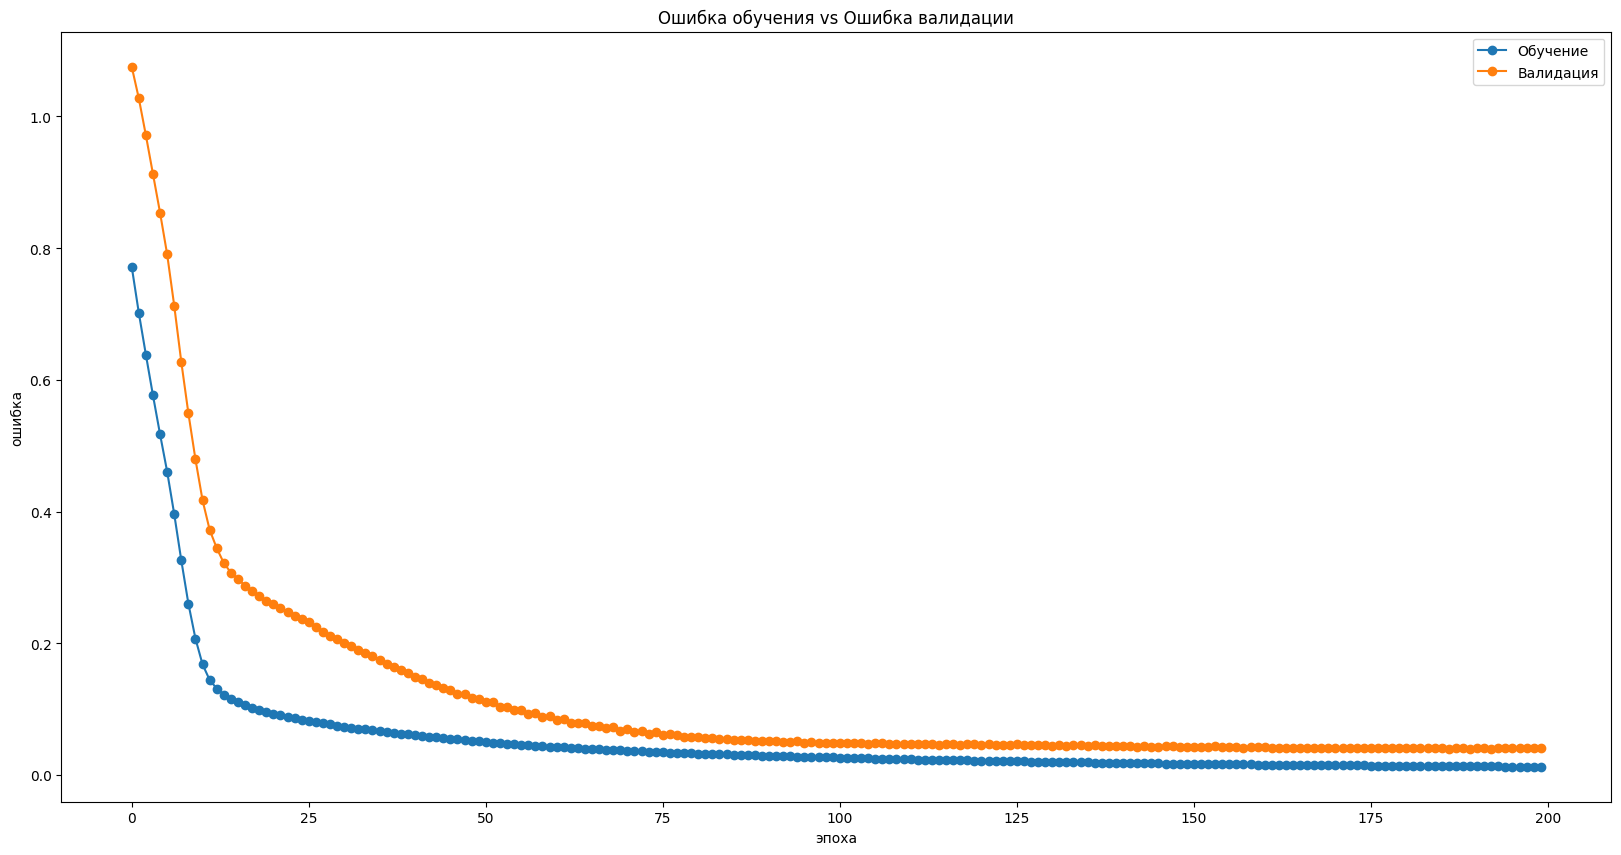

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

## Тест модели

In [27]:
predicts = []
true_values = []
for data in tqdm(test_loader):
  inputs, targets=data[0].to(device),data[1].to(device)
  outputs = model(inputs)

  predicted = outputs.to('cpu').detach().numpy()
  target = targets.to('cpu').detach().numpy()

  predicts.append(price_scaler.inverse_transform(predicted))
  true_values.append(price_scaler.inverse_transform(target))

100%|██████████| 2/2 [00:00<00:00, 354.61it/s]


In [28]:
preds = np.concatenate(predicts).flatten()
trues = np.concatenate(true_values).flatten()
idx = np.arange(len(preds))

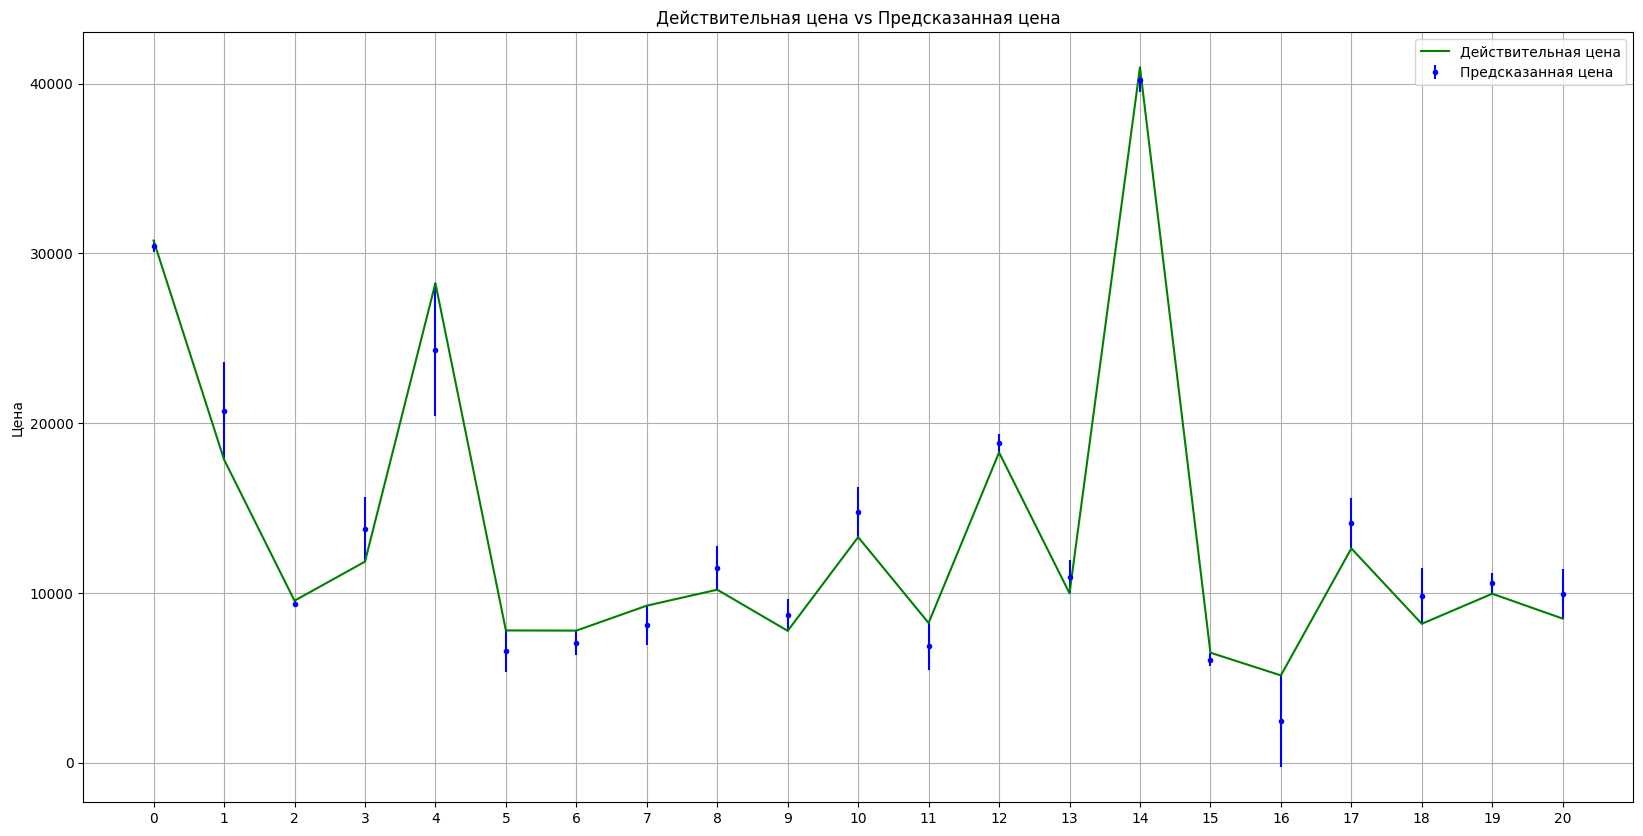

In [29]:
fig,ax=plt.subplots()

plt.errorbar(idx, preds, yerr=abs(trues - preds), fmt='.b')
plt.plot(idx, trues, '-g')
ax.set_xticks(idx)
plt.ylabel('Цена')
plt.legend(['Действительная цена','Предсказанная цена'])
plt.title('Действительная цена vs Предсказанная цена')
plt.grid()
plt.show()

In [30]:
mae = mean_absolute_error(preds, trues)
print("Среднее отклонение предсказанной цены от настоящей на тестовой выборке:", mae)

Среднее отклонение предсказанной цены от настоящей на тестовой выборке: 1329.8033


# Итог

Модель верно предсказывает цену машины с точностью в 1500$ +-.